# Tutorial 3: Integrating Attributions

This first part of this tutorial shows how to generate new attribution scores using integrated gradients and SCimilarity. 

The second section details how to integrate new attributions with pre-computed attributions

Before running this tutorial, you need to:

1. Download the model files folder from [here](https://zenodo.org/records/17903196)
2. Download the cell type-level attributions you are interested in from [here](https://zenodo.org/communities/signature/). For this tutorial, you can download the relevant attributions from [here](https://zenodo.org/records/17905668). The file can be extracted by running "tar -xzf celltype_attributions.tar.gz". This will produce the "celltype_attributions" folder needed for the tutorial below.

In [1]:
import os
from os.path import join
import pandas as pd
import scanpy as sc
from scipy import sparse

from SIGnature import Meta
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# Part 1: Generate Attributions for New Data

### Load SCimilarity Model and Attributions TileDB

In [2]:
from SIGnature.models.scimilarity import SCimilarityWrapper

base_model_fold = "home/model_files/" # change to path where model_files was downloaded
model_path = join(base_model_fold, "scimilarity")
scim = SCimilarityWrapper(model_path=model_path, use_gpu=True) # change to use_gpu=False if no GPU available

In [3]:
# Load custom data
base_folder = "home" # change to base folder of your data
data_file = join(base_folder, "tutorial_dataset.h5ad") # change to path of your data file
adata = sc.read_h5ad(data_file)

### Calculate Attributions using SCimilarity and Integrated Gradients

Attributions collected against SCimilarity model need to be aligned to SCimilarity gene order and then log-normalized.

In [4]:
tadata = scim.preprocess_adata(adata.copy())

In [5]:
# replace "ig" (integrated gradients) with "dl" (deeplift) or "ixg" (input x gradients) for other methods. 
# save attributions with npz_path parameter
npz_file = "custom_attributions.npz"
att = scim.calculate_attributions(
    tadata.X, batch_size=100, method="ig", npz_path=join(base_folder, npz_file)
)

100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


In [6]:
## save attributions if not saved above using npz_path parameter
# npz_file = "custom_attributions.npz"
# sparse.save_npz(matrix=att, file=join(base_folder, npz_file))

# Part 2: Integrate new data with pre-computed attributions

### Create a tiledb for integrating with known matrices

In [7]:
from SIGnature import SIGnature

In [8]:
## Overwrite will take tiledb with the same name [custom_tiledb] and overwrite it with your new one
sig = SIGnature(gene_order=scim.gene_order)
sig.create_tiledb(
    npz_path=join(base_folder, npz_file),
    overwrite=True,
    attribution_tiledb_uri=join(base_folder, "custom_attributions"),
)

Optimizing /gpfs/scratchfs01/site/u/goldm3/signature_revision/custom_attributions
Fragments before consolidation: 1
Fragments after consolidation: 1


### Search existing tiledbs and new tiledb

In [9]:
## Path to cell type attributions downloaded from Zenodo (https://zenodo.org/records/15794176)
ct_base = join(base_folder, "celltype_attributions/")
all_ct = os.listdir(ct_base)

In [10]:
# Analyze all monocyte/macrophage cell populations in database
ctoi = [
    "alveolar macrophage",
    "classical monocyte",
    "intermediate monocyte",
    "macrophage",
    "non-classical monocyte",
]

#### Check genes

In [11]:
ms1_genes = ['S100A8', 'S100A12', 'RETN', 'CLU', 'MCEMP1', 'IL1R2', 'CYP1B1', 'SELL', 
             'ALOX5AP', 'SLC39A8', 'PLAC8', 'ACSL1', 'CD163', 'VCAN', 'HP', 'CTSD', 
             'LGALS1', 'THBS1', 'CES1', 'S100P', 'ANXA6', 'VNN2', 'NAMPT', 'HAMP', 
             'DYSF', 'SDF2L1', 'NFE2', 'SLC2A3', 'BASP1', 'ADGRG3', 'SOD2', 'CTSA', 
             'PADI4', 'CALR', 'SOCS3', 'NKG7', 'FLOT1', 'IL1RN', 'ZDHHC19', 'LILRA5', 
             'ASGR2', 'FAM65B', 'MNDA', 'STEAP4', 'NCF4', 'LBR', 'RP11-295G20.2', 
             'UBR4', 'PADI2', 'NCF1', 'LINC00482', 'RUNX1', 'RRP12', 'HSPA1A', 
             'FLOT2', 'ANPEP', 'CXCR1', 'ECE1', 'ADAM19', 'RP11-196G18.3', 'IL4R', 
             'DNAJB11', 'FES', 'MBOAT7', 'SNHG25', 'RP1-55C23.7', 'CPEB4', 'PRR34-AS1', 
             'HSPA1B', 'LINC01001', 'C1QC', 'SBNO2', 'GTSE1', 'FOLR3', 'STAB1', 'PLK1', 
             'HYI-AS1', 'LINC01281', 'TNNT1', 'AC097495.2', 'CTB-35F21.5', 'C19orf35', 
             'AC109826.1', 'RP11-800A3.7', 'LILRA6', 'PDLIM7', 'NPLOC4', 'C15orf48', 
             'APOBR', 'CSF2RB', 'CTD-2105E13.14', 'C1QB', 'RP11-123K3.9', 'IQGAP3', 
             'GAPLINC', 'CTC-490G23.2', 'JAK3', 'CTC-246B18.10', 'MYO5B']
gene_list = sig.check_genes(ms1_genes)

The following genes are not included: CTC-246B18.10, RP1-55C23.7, C19orf35, RP11-295G20.2, RP11-196G18.3, CTD-2105E13.14, CTB-35F21.5, RP11-123K3.9, AC097495.2, RP11-800A3.7, CTC-490G23.2, HYI-AS1, FAM65B


#### Calculate mean attribution scores for each Cell Type

Iterate through tiledb of each cell type, calculate score, concatenate the metadata

In [12]:
score_name = "MS1"

In [13]:
meta_list = []
for ct in tqdm(ctoi):
    ## Get specific tiledb path for location of interest
    ct_path = join(ct_base, ct)
    ## Load attributions tiledb path for given cell type
    att_tdb_path = join(ct_path, "attributions")
    ## Calculate
    results = sig.query_attributions(
        gene_list,
        return_aggregate=True,
        aggregate_type="mean",
        attribution_tiledb_uri=att_tdb_path,
    )

    ## Example including weights
    # import numpy as np
    # weight_list = np.random.choice([0.5, 1, 2], len(gene_list)).tolist()
    # results = sig.query_attributions(gene_list, return_aggregate=True,
    #               aggregate_type='mean', weights = weight_list,
    #               attribution_tiledb_uri=att_tdb_path)

    ## Example getting individual genes
    # results = sig.query_attributions(gene_list, return_aggregate=False,
    #               attribution_tiledb_uri=att_tdb_path)

    ## Load corresponding cell metadata
    ct_path = join(ct_base, ct)
    meta = pd.read_csv(join(ct_path, "cell_metadata.csv.gz"), index_col=0)

    ## Put score
    meta[score_name] = results
    meta_list.append(meta.copy())

100%|██████████| 5/5 [00:22<00:00,  4.51s/it]


#### Create Meta object with cell metadata and mean attribution scores

In [14]:
big_meta = pd.concat(meta_list)
momac_meta = Meta(big_meta)
# subset to in vivo cells
momac_meta.subset_invivo()
# subset to cells with high prediction scores
momac_meta.subset_hq()

In [15]:
## Calculate mean attributions for new dataset
results = sig.query_attributions(
    gene_list,
    return_aggregate=True,
    aggregate_type="mean",
    attribution_tiledb_uri=join(base_folder, "custom_attributions"),
)

## Load corresponding cell metadata
nmeta = adata.obs

## Put score
nmeta[score_name] = results

#### Integrate datasets and clean disease names

In [16]:
momac_meta.append(nmeta)

In [17]:
figure_disname_dict = {
    "atopic eczema": "Atopic Dermatitis",
    "COVID-19;healthy": "COVID-19 & Healthy (Mixed)",
    "Epstein-Barr virus infection;hemophagocytic syndrome": "EBV-Associated HLH",
    "Immune dysregulation-polyendocrinopathy-enteropathy-X-linked syndrome": "IPEX",
    "mucocutaneous lymph node syndrome": "Kawasaki Disease",
    "systemic scleroderma;interstitial lung disease": "SSC-ILD",
    "thrombocytopenia": "Severe Fever Thrombocytopenia Syndrome",
}

momac_meta.df["disease"] = momac_meta.df["disease"].replace(figure_disname_dict)

#### Calculate hit percentage per sample

In [19]:
# Define hits
hit_col = "MS1"
## 90th percentile
momac_meta.add_hits(
    column_name=hit_col,
    mode="percentile",
    cut_val=90,
    hit_type="above",
    string_append="__hit90p",
)

In [20]:
# calculate hits per sample. Only consider samples with at least 10 cells and diseases with at least 3 samples
samphit_df_90 = momac_meta.samphit_df(
    cell_min=10, samp_min=3, hit_col="MS1__hit90p", num_dis=100
)

#### Plot top diseases by mean hit percentage

Condition 2 (initialized with MS1-like cells) shows high levels, but Condition 1 (which was initialized random counts) is very low.

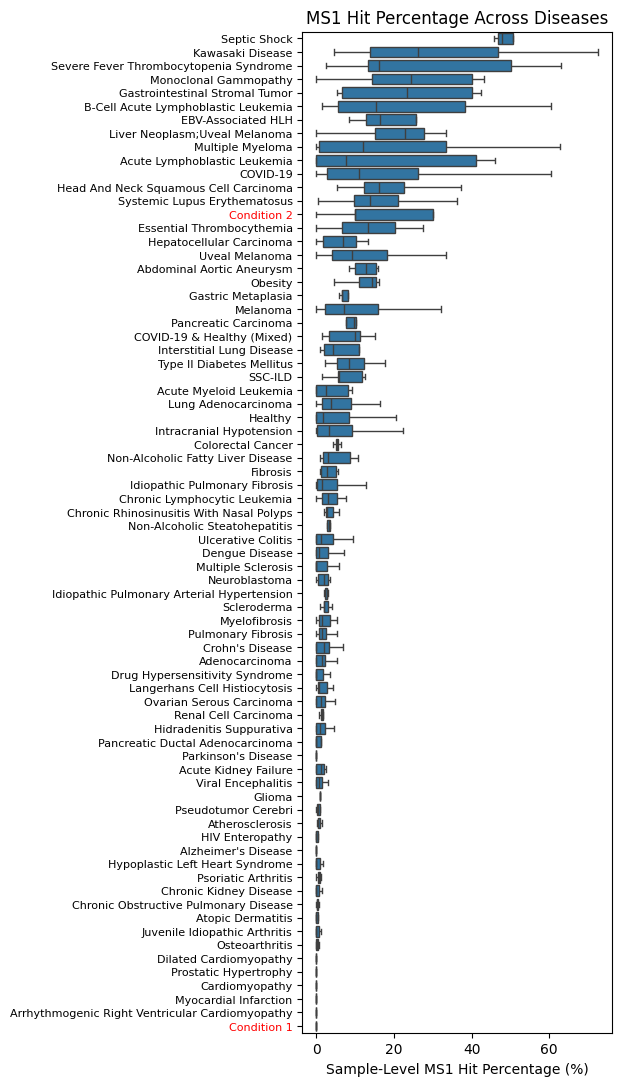

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 13))
sns.boxplot(data=samphit_df_90, y="disease", x="MS1__hit90p", showfliers=False)
ax.set_yticklabels(ax.get_yticklabels(), ha="right", fontsize=8)

for label in ax.get_yticklabels():
    if label.get_text() in ["Condition 1", "Condition 2"]:
        label.set_color("red")
ax.set_title("MS1 Hit Percentage Across Diseases")
ax.set_xlabel("Sample-Level MS1 Hit Percentage (%)")
ax.set_ylabel("")

x_ticks = ax.get_xticks() * 100
ax.set_xticklabels([f"{int(y)}" for y in x_ticks]);